In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import numpy as np
import random

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from PIL import Image

# Load the dataset

In [3]:
attribute_path = "./list_attr_celeba.csv/list_attr_celeba.csv"
eval_path = "./list_eval_partition.csv/list_eval_partition.csv"
images_path = "./img_align_celeba/img_align_celeba/"
attr_df = pd.read_csv(attribute_path, index_col= 'image_id')
eval_df = pd.read_csv(eval_path, index_col = 'image_id')
attr_df.replace(to_replace = -1, value = 0, inplace = True)
data_df =  pd.merge(attr_df["Male"], eval_df, left_on = 'image_id', right_on='image_id')

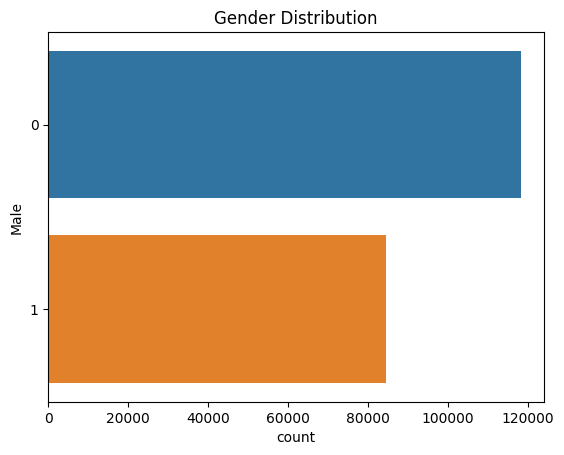

In [4]:
plt.title("Gender Distribution")
sns.countplot(y = 'Male', data = attr_df)
plt.show()

In [45]:
img_size = (224, 224)
batch_size = 32

In [6]:
def create_data_artifacts(training_size ,validation_size, testing_size):
    
    # Training Data
    train_df = data_df[data_df["partition"] == 0].drop('partition', axis = 1)
    male_df = train_df[train_df['Male'] == 1]
    female_df = train_df[train_df['Male'] == 0]

    male_samples = male_df.sample(training_size // 2)
    female_samples = female_df.sample(training_size // 2)

    train_df = pd.concat([male_samples, female_samples])

    # Validation Data
    valid_df = data_df[data_df["partition"] == 1].drop('partition', axis = 1)
    male_df = valid_df[valid_df['Male'] == 1]
    female_df = valid_df[valid_df['Male'] == 0]

    male_samples = male_df.sample(validation_size // 2)
    female_samples = female_df.sample(validation_size // 2)

    valid_df = pd.concat([male_samples, female_samples])

    # Testing Data
    test_df = data_df[data_df["partition"] == 2].drop('partition', axis = 1)
    male_df = test_df[test_df['Male'] == 1]
    female_df = test_df[test_df['Male'] == 0]

    male_samples = male_df.sample(testing_size // 2)
    female_samples = female_df.sample(testing_size // 2)

    test_df = pd.concat([male_samples, female_samples])
    
    # Training Data
    predict_train_images = []
    train_images = []
    train_labels = []

    for index, row in train_df.iterrows():
        image_path = os.path.join(images_path + row.name)
        image = cv2.imread(image_path)
        image = cv2.resize(image, img_size)
        image = np.array(image, dtype = np.float32) / 255.0
        train_images.append(image)
        train_labels.append(row["Male"])
        image = np.reshape(image, (1, 224, 224, 3))
        predict_train_images.append(image)

    train_images = np.array(train_images)
    train_labels = np.array(train_labels)

    # Validation Data

    valid_images = []
    valid_labels = []

    for index, row in valid_df.iterrows():
        image_path = os.path.join(images_path + row.name)
        image = cv2.imread(image_path)
        image = cv2.resize(image, img_size)
        image = np.array(image, dtype = np.float32) / 255.0
        valid_images.append(image)
        valid_labels.append(row["Male"])

    valid_images = np.array(valid_images)
    valid_labels = np.array(valid_labels)

    # Testing Data

    test_images = []
    test_labels = []

    for index, row in test_df.iterrows():
        image_path = os.path.join(images_path + row.name)
        image = cv2.imread(image_path)
        image = cv2.resize(image, img_size)
        image = np.array(image, dtype = np.float32) / 255.0
        test_images.append(image)
        test_labels.append(row["Male"])

    test_images = np.array(test_images)
    test_labels = np.array(test_labels)
    
    return train_images, train_labels, valid_images, valid_labels, test_images, test_labels, predict_train_images

# Load the Model

In [7]:
def custom_loss(y_true, y_pred, mse):
    alpha = 1
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + alpha * mse

In [8]:
def create_algorithm_model(x_model, mse):
    for layer in x_model.layers:
        layer.trainable = False

    #Add new classifier layers on top of the ResNet50 base layers
    x = Flatten()(x_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs = x_model.input, outputs = x)
    model.compile(loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, mse), optimizer='adam', metrics=['accuracy'])
    return model

In [9]:
# Defines a model with the modified architecture
def create_model(x_model):
    for layer in x_model.layers:
        layer.trainable = False

    #Add new classifier layers on top of the ResNet50 base layers
    x = Flatten()(x_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)

    # x = x_model.output
    # x = GlobalAveragePooling2D()(x)
    # x = Dense(1024, activation='relu')(x)
    # predicitions = Dense(1, activation='softmax')(x)
        
    model = Model(inputs = x_model.input, outputs = x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # model.compile(loss=custom_loss, optimizer='adam', metrics=['accuracy'])
    return model 

In [41]:
# Trains the model on the Dataset and prints the accuracy
def FineTune(model, train_images, train_labels, val_images, val_labels, test_images, test_labels, batch_size, file_name):
    history = model.fit(
        train_images,
        train_labels,
        batch_size = batch_size,
        steps_per_epoch = len(train_images) // batch_size,
        validation_data = (val_images, val_labels),
        epochs = 5,
        callbacks=[EarlyStopping(patience=3), ModelCheckpoint('temp.h5', save_best_only=True)]
    )
    
    scores = model.evaluate(test_images, test_labels)
    print("Test Loss:", scores[0])
    print("Test Accuracy:", scores[1])
    
    if file_name != "no":
        model.save_weights("models/" + file_name)
    return model

In [11]:
def find_confident_samples(model, predict_train_images, train_images):
    confident_images = []
    confident_labels = []
    for index, image in enumerate(predict_train_images):
        prediction = model.predict(image)
        if prediction < 0.1 or prediction > 0.9:
            confident_images.append(train_images[index])
            if prediction < 0.1:
                confident_labels.append(0)
            else:
                confident_labels.append(1)
    print(len(confident_labels))

    confident_images = np.array(confident_images)
    confident_labels = np.array(confident_labels)
    return confident_images, confident_labels

# Consistency Regularization 

In [12]:
pertubations = ["color-jitter", "horizontal-flippping"]

def pertubate(image_path):

    img = cv2.imread(image_path)
    order = random.randint(0, 1)
    if order == 0:
        # Define the random color jitter parameters
        brightness = np.random.randint(-30, 30)
        contrast = np.random.uniform(0.5, 1.5)
        saturation = np.random.uniform(0.5, 1.5)
        hue = np.random.randint(-10, 10)

        # Convert image to HSV color space
        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        # Apply brightness, contrast, and saturation adjustments to the image
        img_hsv[:,:,2] = cv2.addWeighted(img_hsv[:,:,2], contrast, 0, brightness, 0)
        img_hsv[:,:,1] = cv2.addWeighted(img_hsv[:,:,1], saturation, 0, 0, 0)

        # Convert the image back to BGR color space
        jittered_img = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)
        
        return jittered_img
    
    if order == 1:
        flipped_img = np.fliplr(img)
        return flipped_img

In [26]:
def pick_generalizable_images(generalizable_size):
    # Generalizable Data 
    generalizable_df = data_df.sample(generalizable_size).drop('partition', axis = 1)
    
    original_images = []
    pertubated_images = []
    
    for index, row in generalizable_df.iterrows():
        try:
            image_path = os.path.join(images_path + row.name)
            image = cv2.imread(image_path)
            image = cv2.resize(image, img_size)
            image = np.array(image, dtype = np.float32) / 255.0
            image = np.reshape(image, (1, 224, 224, 3))
            original_images.append(image)
            
            pertubated_image = pertubate(image_path)
            pertubated_image = cv2.resize(pertubated_image, img_size)
            pertubated_image = np.array(pertubated_image, dtype = np.float32) / 255.0
            pertubated_image = np.reshape(pertubated_image, (1, 224, 224, 3))
            pertubated_images.append(pertubated_image)
        except Exception as err:
            print("Failed at Index", index, " Erros is:", err)
        
    return original_images, pertubated_images

In [24]:
def calculate_mse(model, generalizable_size):
    
    original_images, pertubated_images = pick_generalizable_images(generalizable_size)
    mean_square_error = 0
    
    for index, original_image in enumerate(original_images):
        pertubated_image = pertubated_images[index]
        original_prediction = model.predict(original_image)
        pertubated_prediction = model.predict(pertubated_image)
        if (original_prediction > 0.5 and pertubated_prediction > 0.5) or (original_prediction < 0.5 and pertubated_prediction < 0.5):
            mean_square_error += 0
        else:
            mean_square_error += 1
    mean_square_error = mean_square_error / generalizable_size
    return mean_square_error


# Algorithm Execution

In [43]:
labelled_training_samples = [100, 200, 500, 1000]
cotrainteach_sample = 200
num_iterations_alg = 4
total_sample_size = len(data_df)

In [ ]:
for i in range(len(labelled_training_samples)):    
    labelled_data_size = labelled_training_samples[i]
    print("Training on Labelled Size:", labelled_data_size)
    # Initial Training
    training_size = labelled_data_size
    validation_size = training_size // 3
    testing_size = training_size // 3 
    train_images, train_labels, valid_images, valid_labels, test_images, test_labels, pretrained_images = create_data_artifacts(training_size, validation_size, testing_size)
    train_images1, train_labels1, valid_images1, valid_labels1, test_images1, test_labels1, pretrained_images1 = create_data_artifacts(training_size, validation_size, testing_size)
    
    
    vgg1 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    vgg2 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    vgg1 = create_model(vgg1)
    vgg2 = create_model(vgg2)
    
    filename1 = str(training_size) + "_vgg1_fine_tuned.h5"
    filename2 = str(training_size) + "_vgg2_fine_tuned.h5"
    
    # vgg1 = FineTune(vgg1, train_images, train_labels, valid_images, valid_labels, test_images, test_labels, batch_size, filename1)
    # vgg2 = FineTune(vgg1, train_images1, train_labels1, valid_images1, valid_labels1, test_images1, test_labels1, batch_size, filename2)
    
    print("Model Weights for Initial Training saved for Labelled size : ", labelled_data_size)
    
    generalizable_size = total_sample_size - labelled_data_size
    
    print("Calculating Mean Square Error Losses")
    vgg1_mse = calculate_mse(vgg1, generalizable_size)
    vgg2_mse = calculate_mse(vgg2, generalizable_size)
    
    print("Consistency Regularization Loss Computed")
    
    # Algorithm Training
    for j in range(num_iterations_alg):
        
        print("Algorithm Iteration :", j+1)
        
        training_size = cotrainteach_sample
        validation_size = training_size // 3
        testing_size = training_size // 3
        
        vgg1 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        vgg2 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
        vgg1 = create_algorithm_model(vgg1, vgg1_mse)
        vgg2 = create_algorithm_model(vgg2, vgg2_mse)
        
    
        vgg1.load_weights('models/' + filename1)
        vgg2.load_weights('models/' + filename2)
        
        # Unsupervised Part - A 
        train_images1, train_labels1, valid_images1, valid_labels1, test_images1, test_labels1, predict_train_images1 = create_data_artifacts(training_size, validation_size, testing_size)
        train_images2, train_labels2, valid_images2, valid_labels2, test_images2, test_labels2, predict_train_images2 = create_data_artifacts(training_size, validation_size, testing_size)
        
        print("Finding Confident Samples")
        vgg1_confident_images, vgg1_confident_labels = find_confident_samples(vgg1, predict_train_images1, train_images1)
        vgg2_confident_images, vgg2_confident_labels = find_confident_samples(vgg2, predict_train_images2, train_images2)
        
        if j % 2 == 1:
        # Co- Training
            print("Performing Co- Training")
            vgg1 = FineTune(vgg1, vgg1_confident_images, vgg1_confident_labels, valid_images1, valid_labels1, test_images1, test_labels1, batch_size, "no")
            vgg2 = FineTune(vgg2, vgg2_confident_images, vgg2_confident_labels, valid_images2, valid_labels2, test_images2, test_labels2, batch_size, "no")
        else:
            # Co - Teaching
            print("Performing Co- Teaching")
            vgg1 = FineTune(vgg1, vgg2_confident_images, vgg2_confident_labels, valid_images2, valid_labels2, test_images2, test_labels2, batch_size, "no")
            vgg2 = FineTune(vgg2, vgg1_confident_images, vgg1_confident_labels, valid_images1, valid_labels1, test_images1, test_labels1, batch_size, "no")
    
    filename1  = str(training_size) + "_vgg1_algorithm.h5"
    filename2  = str(training_size) + "_vgg2_algorithm.h5"
    
    vgg1.save_weights("models/" + filename1)
    vgg2.save_weights("models/" + filename2)
    
    print("Model Weights for Algorithm saved for Labelled size : ", labelled_data_size)
        

# Results

In [ ]:
for file in os.listdir("models/"):
    if file.endswith(".h5"):
        print("Computing Resuts for Model: ", file)
        vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        vgg = create_model(vgg1)
        vgg.load_weights("models/" + file)
        
        test_images, test_labels, _, _, _, _, _ = create_data_artifacts(25000, 2, 2)
        scores = vgg.evaluate(test_images, test_labels)
        print("Test Loss:", scores[0])
        print("Test Accuracy:", scores[1])
        
        